In [93]:
import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from torchsummary import summary
import visdom
import warnings
warnings.filterwarnings('ignore')

set seed to get reproducible results

In [94]:
seed =0
torch.backends.cudnn.deterministic= True
torch.backends.cudnn.benchmark= False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


In [95]:
#model = sbm.PhaseNet.from_pretrained("instance")
sbm.EQTransformer.list_pretrained()

model = sbm.EQTransformer.from_pretrained("original")
#model = sbm.PhaseNet(phases="PSN")
model.cuda();
data = sbd.Iquique(sampling_rate=100)
train, dev, test = data.train_dev_test()
model.cuda();
#summary(model, (3, 6000))
sbm.EQTransformer.list_pretrained()


2022-10-11 12:58:26,072 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


['ethz',
 'geofon',
 'instance',
 'iquique',
 'lendb',
 'neic',
 'original',
 'original_nonconservative',
 'scedc',
 'stead']

for param in model.parameters():
    param.requires_grad = False
    #print(param.requires_grad)

model.out.weight.requires_grad = True
model.up4.weight.requires_grad = True
#model.up3.weight.requires_grad = True
#model.up2.weight.requires_grad = True
#model.up1.weight.requires_grad = True
#model.conv4.conv.weight.requires_grad = True
#model.conv3.conv.weight.requires_grad = True

#for param in model.parameters():
    #param.requires_grad = False
    #print(param.requires_grad)

In [96]:
from collections import Counter
data = sbd.Iquique(sampling_rate=100)
#data = sbd.ETHZ(sampling_rate=100)
train, dev, test = data.train_dev_test()

2022-10-11 12:58:26,800 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


In [97]:
generator = sbg.GenericGenerator(data)

@generator.augmentation
def print_state_dict(state_dict):
    print(state_dict)

generator[2];

{'X': (array([[198.29475309, 203.29475309, 210.29475309, ..., -28.70524691,
        -43.70524691, -61.70524691],
       [-67.81648663, -50.81648663, -49.81648663, ..., -91.81648663,
        -80.81648663, -66.81648663],
       [ 81.47247942,  66.47247942,  56.47247942, ..., -75.52752058,
        -55.52752058, -43.52752058]]), {'source_origin_time': '2014-05-01T00:52:20.970000Z', 'source_latitude_deg': -19.4527, 'source_longitude_deg': -69.9762, 'source_depth_km': 57.95, 'path_back_azimuth_deg': 329.936310182, 'station_network_code': 'DG', 'station_code': 'IN17', 'trace_channel': 'HH*', 'station_location_code': nan, 'station_latitude_deg': -20.48, 'station_longitude_deg': -69.35, 'station_elevation_m': 1278.0, 'trace_name': 'bucket0$2,:3,:15552', 'trace_sampling_rate_hz': 100, 'trace_completeness': 1.0, 'trace_has_spikes': False, 'trace_start_time': '2014-05-01T00:52:20.740000Z', 'trace_P_arrival_sample': 2000.0, 'trace_S_arrival_sample': 3551.0, 'trace_name_original': 'DG.IN17.', 'trace

In [98]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S",
}

In [99]:
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=6000, strategy="pad"),
    sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=0),
    #sbg.ChannelDropout(),
    #sbg.GaussianNoise(scale=(0, 0.3)),
    #sbg.AddGap(),
    #sbg.RandomArrayRotation()
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)

In [100]:
batch_size = 1
num_workers = 1  # The number of threads used for loading data

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding)
dev_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding)

In [101]:
import pandas as pd
import numpy as np
from data_preprocessing import Data_Preprocessing
from picks_comparison import Picks_Comparison
def phase_accuracy():
    start_year_analysis = 2012
    start_day_analysis = 182
    end_year_analysis = 2012
    end_day_analysis = 182
    time_lag_threshold = 450
    P_th = 0.3
    S_th = 0.15

    obj = Data_Preprocessing (start_year_analysis, start_day_analysis,
                        end_year_analysis, end_day_analysis)

    stream = obj.get_waveforms_chile()
    #client = Client("GFZ")
    #stream = sbm.DeepDenoiser.from_pretrained("original").annotate(stream)

    picks,detection = model.classify(stream, batch_size=256, P_threshold=P_th, S_threshold=S_th, parallelism=1)


    pick_df = []
    for p in picks:
        pick_df.append({
            "id": p.trace_id,
            "timestamp": p.peak_time.datetime,
            "prob": p.peak_value,
            "type": p.phase.lower()
        })

    event_picks = pd.DataFrame(pick_df)



    picks_obj = Picks_Comparison (start_year_analysis, 
                start_day_analysis,
                end_year_analysis,
                end_day_analysis, event_picks)

    all_dists_p, all_dists_s = picks_obj()

    p_picks_acc = all_dists_p[np.abs(all_dists_p) < 450]/1000
    s_picks_acc = all_dists_s[np.abs(all_dists_s) < 450]/1000
    return len(p_picks_acc)/len(all_dists_p), len(s_picks_acc)/len(all_dists_s)

In [102]:
learning_rate = 1e-3
epochs = 10
loss_weight = torch.tensor([1,1,1]).to(model.device) # DPS
#loss_weight = torch.reshape(loss_weight, (1,3,1))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)
cross_loss = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()


def loss_fn(y_pred, y_true, eps=1e-5):

    loss_detec = criterion(y_pred[0].float(), y_true[:,0,:].float())
    loss_p = criterion(y_pred[1].float(), y_true[:,1,:].float())
    loss_s = criterion(y_pred[2].float(), y_true[:,2,:].float())
    #loss = (loss_weight[0]*loss_detec + loss_weight[1]*loss_p+ loss_weight[2]*loss_p)/3
    loss = loss_p
    return loss


import torch
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        '''
        :param inputs: batch_size * dim
        :param targets: (batch,)
        :return:
        '''
        bce_loss = F.cross_entropy(inputs, targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

focal_loss = FocalLoss()

In [103]:
def train_loop(dataloader):
    train_loss = 0
    size = len(dataloader.dataset)
    print(size)
    #batch = next(iter(dataloader))
    i = 0
    for batch_id, batch in enumerate(dataloader):
        #print(batch_id)
        #print(len(batch))
        # Compute prediction and loss
        #p_picks_acc, s_picks_acc = phase_accuracy()
        #print(p_picks_acc)
        #print(s_picks_acc)
        pred = model(batch["X"].to(model.device))
        loss = loss_fn(pred, batch["y"].to(model.device))
        print(loss)
        print('--------------------')
        print(pred.max())
    
        #loss = dic_loss(pred, batch["y"].to(model.device))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss +=  loss

        if batch_id % 2 == 0:
            loss, current = loss.item(), batch_id * batch["X"].shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            p_picks_acc, s_picks_acc = phase_accuracy()
            print(p_picks_acc)
            print(s_picks_acc)

        i += 1
    train_loss /= i
    print('-------------------------------------')
    print(f"Train avg loss: {train_loss:>8f} \n")
    return  train_loss  

def test_loop(dataloader):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            pred = model(batch["X"].to(model.device))
            #test_loss += dic_loss(pred, batch["y"].to(model.device)).item()
            test_loss += loss_fn(pred, batch["y"].to(model.device)).item()

    test_loss /= num_batches
    print('-------------------------------------')
    print(f"Test avg loss: {test_loss:>8f} \n")
    return test_loss

In [104]:
import matplotlib.pyplot as plt
tot_train_loss = np.zeros((1, epochs))
tot_test_loss = np.zeros((1, epochs))

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader)
    break
    tot_train_loss[0,t]= train_loss
    model.eval()
    test_loss = test_loop(dev_loader)
    tot_test_loss[0,t]= test_loss

Epoch 1
-------------------------------
8040
tensor(0.0640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
--------------------
tensor([[[-0.0514, -0.0400, -0.0231,  ..., -0.1404, -0.1249, -0.1249],
         [ 0.0745,  0.0703,  0.0670,  ...,  0.0287,  0.0278,  0.0442],
         [-0.0281, -0.0289, -0.0334,  ...,  0.0087,  0.0229,  0.0494]]])


ZeroDivisionError: division by zero

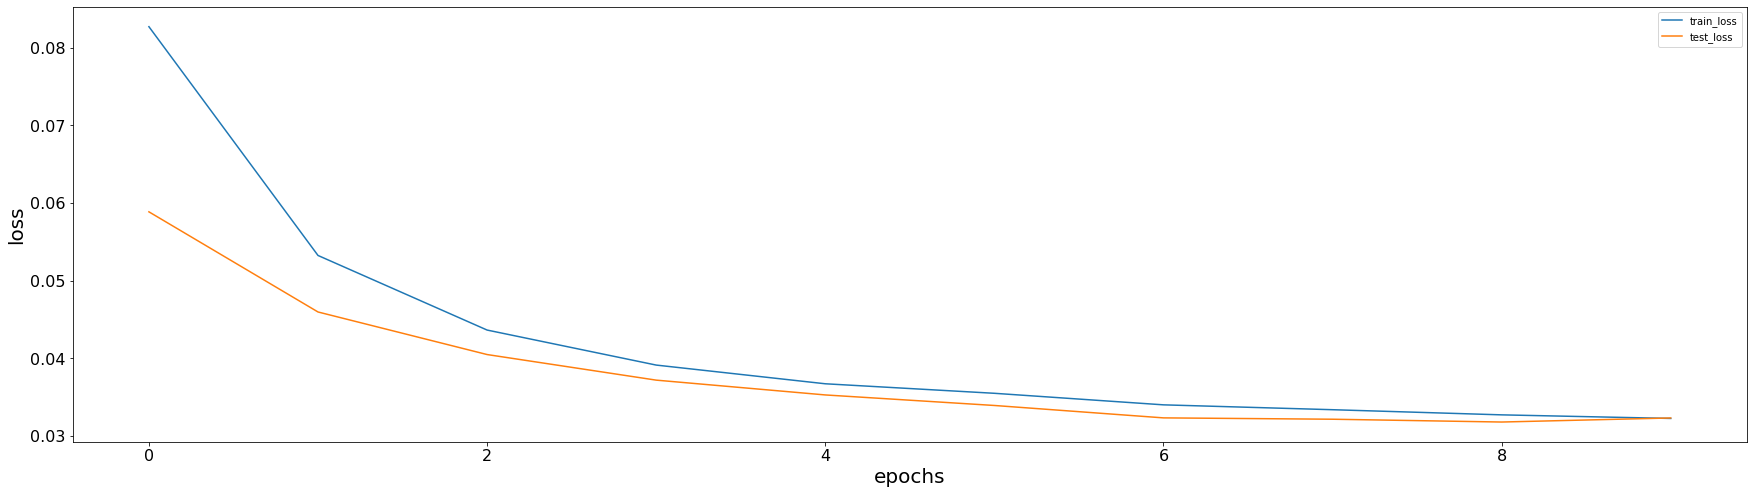

In [ ]:
plt.plot (tot_train_loss[0,:], label='train_loss')
plt.plot (tot_test_loss[0,:], label='test_loss')
plt.rcParams["figure.figsize"] = (30,8)
plt.xlabel('epochs', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc='upper right')


In [ ]:
#bbbbbbbbbbbbbb
#model.get_model_args()
#model

In [ ]:
'''
client = Client("ETH")
t = UTCDateTime("2019-11-04T00:59:46.419800Z")
stream = client.get_waveforms(network="CH", station="EMING", location="*", channel="HH?", starttime=t-30, endtime=t+50)
out = model.annotate(stream)
'''
import pandas as pd
import numpy as np
from data_preprocessing import Data_Preprocessing
from picks_comparison import Picks_Comparison

start_year_analysis = 2012
start_day_analysis = 182
end_year_analysis = 2012
end_day_analysis = 182
time_lag_threshold = 450
P_th = 0.3
S_th = 0.15

obj = Data_Preprocessing (start_year_analysis, start_day_analysis,
                    end_year_analysis, end_day_analysis)

stream = obj.get_waveforms_chile()
#client = Client("GFZ")
#stream = sbm.DeepDenoiser.from_pretrained("original").annotate(stream)

picks,detection = model.classify(stream, batch_size=256, P_threshold=P_th, S_threshold=S_th, parallelism=1)




In [ ]:

#Counter([p.phase for p in picks])  # Output number of P and S picks

In [ ]:
pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })

event_picks = pd.DataFrame(pick_df)



picks_obj = Picks_Comparison (start_year_analysis, 
            start_day_analysis,
            end_year_analysis,
            end_day_analysis, event_picks)

all_dists_p, all_dists_s = picks_obj()

/home/javak/Transfer-Deep-Learning-chile-subduction-zone/transfer_learning/picks_comparison.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S_picks[['station_code', 'others']] = df_S_picks['id'].str.split('.', 1, expand=True)
/home/javak/Transfer-Deep-Learning-chile-subduction-zone/transfer_learning/picks_comparison.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_S_picks[['station_code', 'others']] = df_S_picks['id'].str.split('.', 1, expand=True)
/home/javak/Transfer-Deep-Learning-chile-s

f = event_picks[event_picks.prob>0.6]

picks_obj = Picks_Comparison (start_year_analysis, 
            start_day_analysis,
            end_year_analysis,
            end_day_analysis, f)

all_dists_p, all_dists_s = picks_obj()

In [ ]:
len(picks)

7404

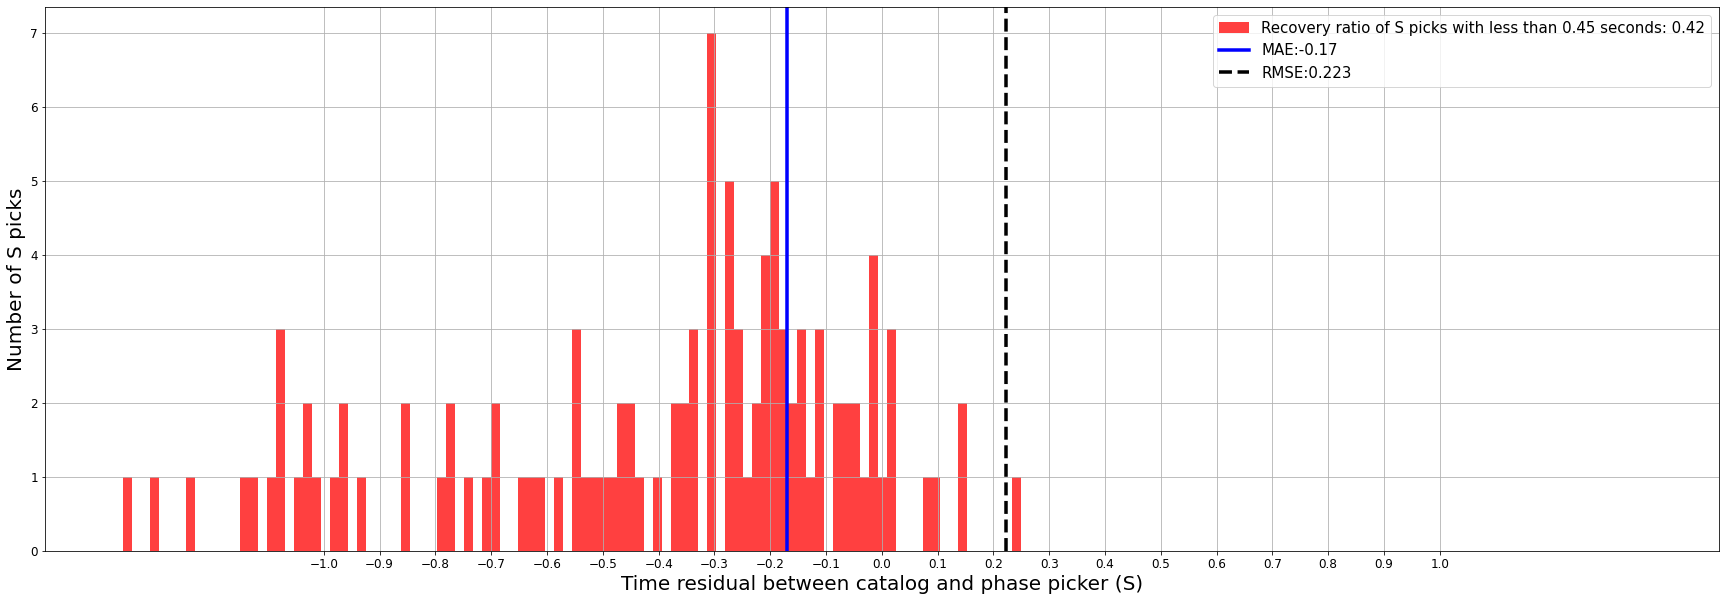

In [ ]:
# Filter the time lag with the given threshold and capture the picks with more than .. second time lag
dists_filter_lag_time_m=all_dists_s[np.abs(all_dists_s) < 2000]/1000

# Perform S picks Quality control of PhaseNet by using existing S picks catalog with more than a given time lag
fig_lag_m, ax_lag_m = plt.subplots(figsize=(30,10))

label_more = '{0}{1}'.format('Recovery ratio of S picks with less than 0.45 seconds: ', round (all_dists_s[np.abs(all_dists_s) < time_lag_threshold].shape[0]/all_dists_s.shape[0],3))

n_lag_m, bins_lag_m, patches_lag_m = ax_lag_m.hist(dists_filter_lag_time_m, 100, density=False, facecolor='r', alpha=0.75, label=label_more)
#steps = (max(dists_filter_lag_time_m) - min(dists_filter_lag_time_m))/40
steps = 0.1
#plt.xticks(np.arange(min(dists_filter_lag_time_m), max(dists_filter_lag_time_m), step=steps))
plt.xticks(np.arange(-1, 1.1, step=steps))
plt.xlabel('Time residual between catalog and phase picker (S)', fontsize=20)
plt.ylabel('Number of S picks', fontsize=20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

filter_tim_lag = all_dists_s[np.abs(all_dists_s) < 450]/1000
MAE = np.sum(filter_tim_lag)/filter_tim_lag.shape[0]
RMSE = np.sqrt (np.sum(filter_tim_lag**2)/filter_tim_lag.shape[0])
plt.axvline(MAE, color='blue', label='MAE:'+str(round (MAE,3)),linewidth=3.5)
plt.axvline(RMSE, color='black', label='RMSE:'+str(round (RMSE,3)), linestyle="--", linewidth=3.5)

#plt.title('Common S picks distribution with less than 2 seconds time residual (2012-01-01 to 2012-12-31)', fontsize=24, pad=23)
#plt.xlim(min(bins_lag_m), max(bins_lag_m))
plt.xlim([-1.5,1.5])
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()



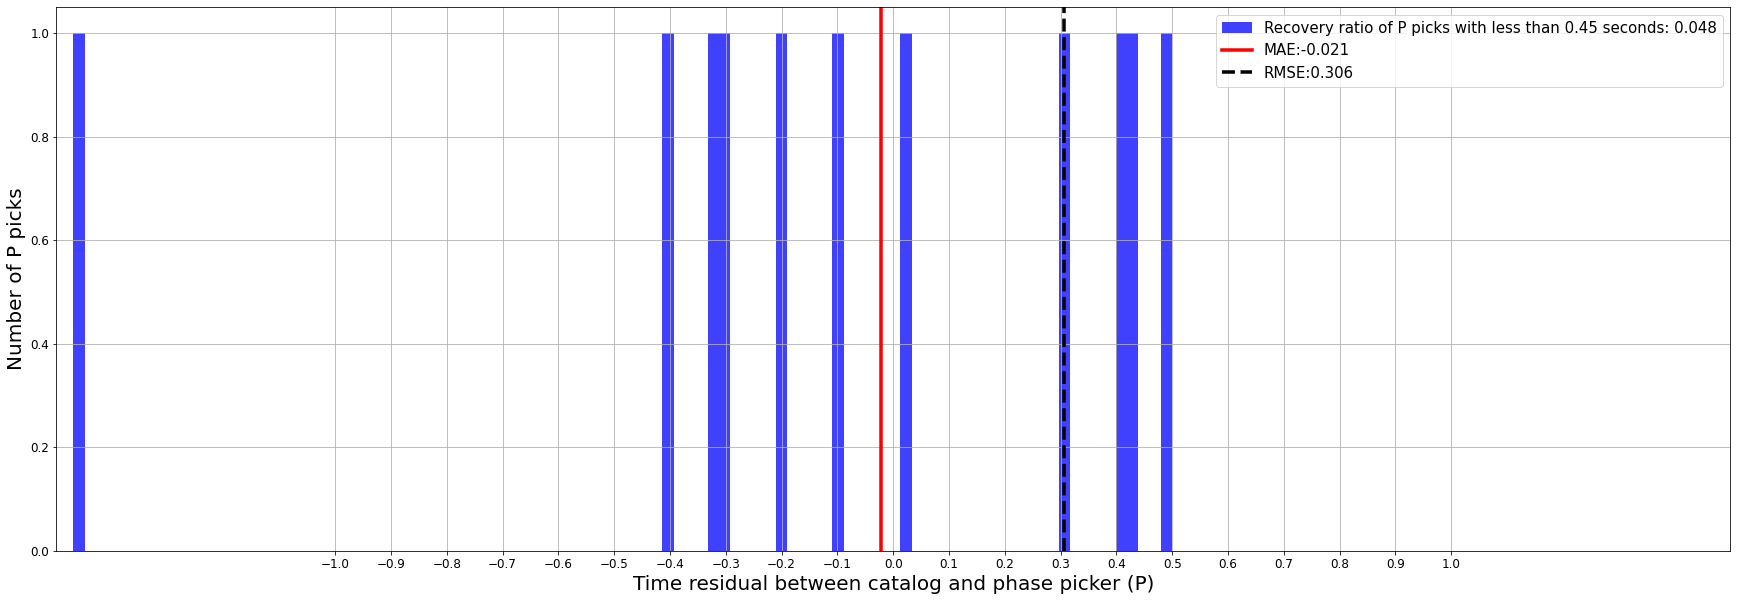

In [ ]:
# Filter the time lag with the given threshold and capture the picks with more than .. second time lag
dists_filter_lag_time_m=all_dists_p[np.abs(all_dists_p) < 2000]/1000

# Perform S picks Quality control of PhaseNet by using existing S picks catalog with more than a given time lag
fig_lag_m, ax_lag_m = plt.subplots(figsize=(30,10))

label_more = '{0}{1}'.format('Recovery ratio of P picks with less than 0.45 seconds: ', round (all_dists_p[np.abs(all_dists_p) < time_lag_threshold].shape[0]/all_dists_p.shape[0],3))

n_lag_m, bins_lag_m, patches_lag_m = ax_lag_m.hist(dists_filter_lag_time_m, 100, density=False, facecolor='blue', alpha=0.75, label=label_more)
#steps = (max(dists_filter_lag_time_m) - min(dists_filter_lag_time_m))/40
steps = 0.1
#plt.xticks(np.arange(min(dists_filter_lag_time_m), max(dists_filter_lag_time_m), step=steps))
plt.xticks(np.arange(-1, 1.1, step=steps))
plt.xlabel('Time residual between catalog and phase picker (P)', fontsize=20)
plt.ylabel('Number of P picks', fontsize=20)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

filter_tim_lag = all_dists_p[np.abs(all_dists_p) < 450]/1000
MAE = np.sum(filter_tim_lag)/filter_tim_lag.shape[0]
RMSE = np.sqrt (np.sum(filter_tim_lag**2)/filter_tim_lag.shape[0])
plt.axvline(MAE, color='r', label='MAE:'+str(round (MAE,3)),linewidth=3.5)
plt.axvline(RMSE, color='black', label='RMSE:'+str(round (RMSE,3)), linestyle="--", linewidth=3.5)

#plt.title('Common S picks distribution with less than 2 seconds time residual (2012-01-01 to 2012-12-31)', fontsize=24, pad=23)
#plt.xlim(min(bins_lag_m), max(bins_lag_m))
plt.xlim([-1.5,1.5])
plt.grid(True)
plt.legend(loc='upper right', fontsize=15)
plt.show()

